# MCMC y diagnóstico del muestro

In [7]:
import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as ipyw

In [8]:
az.style.use('arviz-doc')

## Objetivos

* Obtener nociones básicas de métodos de Markov Chain Monte Carlo y su rol en estadística Bayesiana

* Discutir algunos de los métodos de diagnóstico del muestreo más usados

El teorema de Bayes, tiene una formulación que a primera vista parece muy inocente. Tan solo cuatro términos relacionados por una multiplicación y una división.

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

Pareciera que no sirve de mucho y que es fácil de calcular. Sin embargo, ambas apreciaciones son incorrectas. El resto de los capítulos se centran en mostrar contra ejemplos a la primera aseveración, asi que veamos por que a veces su cálculo puede ser dificil y se requieren métodos numéricos.

La razón está en el cálculo del likelihood marginal. El cual toma la forma de una integral.

$$
{p(\boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
$$

Esta integral suele ser dificil de resolver. Veamos, esta expresión nos dice que debemos evaluar el likelihood para cada uno de los posibles valores del prior $\theta$. Estrictamente no podemos dejar ningún valor afuera, ni siquera focalizarnos en las combinaciones de prior y likelihood que resulten en valores de alta probabilidad para el likelihood (area gris en la siguiente figura). No, debemos evaluar todas y cada una de las posibilidades. Además si $\theta$ representa un solo parámetro desconocido (como en el modelo beta-binomial) entonces solo hay que resolver una integral, pero si $\theta$ representa dos parámetros (como en el modelo Gaussiano) entonces la integral será doble. En definitiva la integral tendrá tantas dimensiones como parámetros el modelo.

Para algunos pocos problemas es posible calcular el posterior de forma analítica. Esto ya lo vimos para el modelo beta-binomial donde el posterior es:


$$
p(\theta \mid y) \propto \operatorname{Beta}(\alpha_{a priori} + y, \beta_{a priori} + N - y)
$$


Pero en general no tenemos expresiones analíticas y entonces debemos confiar en métodos numéricos.

## Método de la grilla

El método de grilla es un enfoque simple de fuerza bruta. La idea central es que incluso si no somos
capaces de calcular todo la distribución a posteriori, en general si somos capaces de evaluar el
a priori y el likelihood punto-a-punto.

Para un modelo con un solo parámetro el método de la grilla se puede resumir de la siguiente forma:

* Encuentre un intervalo razonable para el parámetro (el prior debe dar algunas pistas).

* Defina una grilla de puntos (generalmente equidistantes) en ese intervalo.

* Para cada punto de la grilla, evalue el prior y el likelihood en ese punto y multiplique

In [9]:
def a_posteriori_grilla(grilla=10, a=1, b=1, caras=6, tiradas=9):
    grid = np.linspace(0, 1, grilla)
    prior = pz.Beta(a, b).rv_frozen.pdf(grid)
    likelihood = pz.Binomial(n=tiradas, p=grid).rv_frozen.pmf(caras)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
    ax[0].set_title('caras = {}\ntiradas = {}'.format(caras, tiradas))
    for i, (e, e_n) in enumerate(zip([prior, likelihood, posterior], ['a priori', 'likelihood', 'a posteriori'])):
        ax[i].set_yticks([])
        ax[i].plot(grid, e, 'o-', label=e_n)
        ax[i].legend(fontsize=14)


interact(a_posteriori_grilla, grilla=ipyw.IntSlider(min=2, max=100, step=1, value=15), a=ipyw.FloatSlider(min=1, max=7, step=1, value=1), b=ipyw.FloatSlider(
    min=1, max=7, step=1, value=1), caras=ipyw.IntSlider(min=0, max=20, step=1, value=6), tiradas=ipyw.IntSlider(min=0, max=20, step=1, value=9));

interactive(children=(IntSlider(value=15, description='grilla', min=2), FloatSlider(value=1.0, description='a'…

Podemos obtener una mejor aproximación aumentando el número de puntos de la cuadrícula. Esta estrategia puede ser útil en unas pocas dimensiones (parámetros). Pero no escala. Supongamos que para el grado de precisión que necesitamos, 100 puntos fuesen suficiente. Para el mismo grado de precisión pero con 2 parámetros necesitariamos 10000 puntos y para 10 parámetros 1e+20 puntos! Además en espacios de alta dimensión se dan una serie de fenómemos conocidos como concentración de la medida o maldición de la dimensionalidad. Por ejemplo:

* En una hiper-esfera casi todo el volumen está en la superficie. Es decir, si uno pelara una hiper-naranja se quedaría casi sin naranja!

* En un hyper-cubo la masa se concentra en las esquinas
 
* En una Gaussiana hiper-dimensional casi toda la masa está lejos de la moda

La idea de evaluar punto a punto es buena, pero la idea de construir una grilla predefinida solo funciona en bajas dimensiones.

## Markov Chain Monte Carlo (MCMC)

Esta es una familia muy extensa de métodos utilizados para resolver muchos problemas, entre los que se encuentra el cálculo del posterior. Conceptualmente se puede pensar a estos métodos como generalizaciones del método de la grilla, ya que también se basan en la posibilidad de realizar evaluaciones punto a punto del prior y likelihood. La diferencia crucial es que en vez de utilizar una grilla predefinida el método realiza evaluaciones que progresivamente se concentran en regiones de alta probabilidad. No solo eso si no que eventualmente el método devolverá muestras de forma proporcional a la probabilidad a posteriori. Es decir si una región es 3 veces más probable que otra obtendremos 3 veces más muestras de esa región que de la otra.

A muy grandes razgos los métodos MCMC, constan de dos pasos

1. Generar un nuevo punto a partir de perturbar uno preexistente.
2. Aceptar o rechazar ese nuevo punto de forma probabilista y comparando la probabilidad del punto preexistente y del nuevo punto.



## Metropolis-Hastings

Metropolis-Hastings no es un algoritmo muy moderno o particularmente eficiente, pero Metropolis-Hastings es simple de entender y también proporciona una base para comprender métodos más sofisticados y poderosos. 

El algoritmo Metropolis-Hasting se define de la siguiente manera:

1. Inicialice el valor del parámetro $\boldsymbol{X}$ en $x_i$
2. Utilice una distribución de propuesta $q(x_{i + 1} \mid x_i)$ para generar un nuevo valor $x_{i + 1}$
3. Calcule la probabilidad de aceptar el nuevo valor como:

$$
p_a (x_{i + 1} \mid x_i) = \min \left (1, \frac{p(x_{i + 1}) \; 
q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
\label{acceptance_prob}
$$

4. Si $p_a > R$ donde $R \sim \mathcal{U}(0, 1)$, guarde el nuevo valor; de lo contrario, guarde el anterior.
5. Iterar de 2 a 4 hasta que se haya generado una muestra de valores \textit{suficientemente grande}


El algoritmo Metropolis es muy general y se puede usar en aplicaciones no Bayesianas, pero para la presente discusión, $p(x_i)$ es la densidad del posterior evaluada en el valor del parámetro $x_i$. Observe que si $q$ es una distribución simétrica, los términos $q(x_i \mid x_{i + 1})$ y $q(x_{i + 1} \mid x_i)$ se cancelarán (conceptualmente significa que es igualmente probable que vayamos de $x_{i+1}$ a $x_i$ o de $x_{i}$ a $x_{i+1}$), dejando solo un cociente entre el psoterior evaluado en dos puntos. Este algoritmo siempre aceptará moverse de una región de baja probabilidad a una más alta y aceptará probabilísticamente moverse de una región de alta a una baja probabilidad.

¡Otra observación importante es que el algoritmo Metropolis-Hastings no es un método de optimización! No nos importa encontrar el valor del parámetro con la máxima probabilidad, queremos _explorar_ la distribución $p$. Es decir aún si el método encuentra un máximo aún puede moverse a regiones de probabilidades más bajas.

Para hacer las cosas más concretas, intentemos resolver el modelo Beta-Binomial. 

\begin{align}
\begin{split}
    \theta \sim &\; \text{Beta}(\alpha, \beta) \\
    Y \sim &\; \text{Bin}(n=1, p=\theta)
\label{eq:beta_binomial}
\end{split}
\end{align}

Este modelo tiene una solución analítica. Pero supongamos que no sabemos cómo calcular el posterior y, por lo tanto, implementaremos el algoritmo Metropolis-Hastings usando Python. 

In [10]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

También necesitamos datos, por lo que generaremos algunos datos falsos aleatorios para este propósito.

In [11]:
Y = stats.bernoulli(0.7).rvs(20)

Y finalmente ejecutamos nuestra implementación del algoritmo Metropolis-Hastings:

In [13]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5 
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)  
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ

En la línea 9 del bloque de código anterior generamos un valor propuesto muestreando una distribución Normal con desviación estándar `can_sd`. En la línea 10 evaluamos el posterior en el nuevo valor generado `θ_can` y en la línea 11 calculamos la probabilidad de aceptación. En la línea 20 guardamos un valor de `θ` en el array `trace`.  Dependiendo del resultado de la comparación en la línea 13, el valor guardado será nuevo o repetiremos el anterior.

El primer panel de la siguiente figura muestra cada valor muestreado en cada paso, y el panel de la derecha el histograma de esos valores. El resultado parece razonable. Nada mal para unas pocas lineas de código!

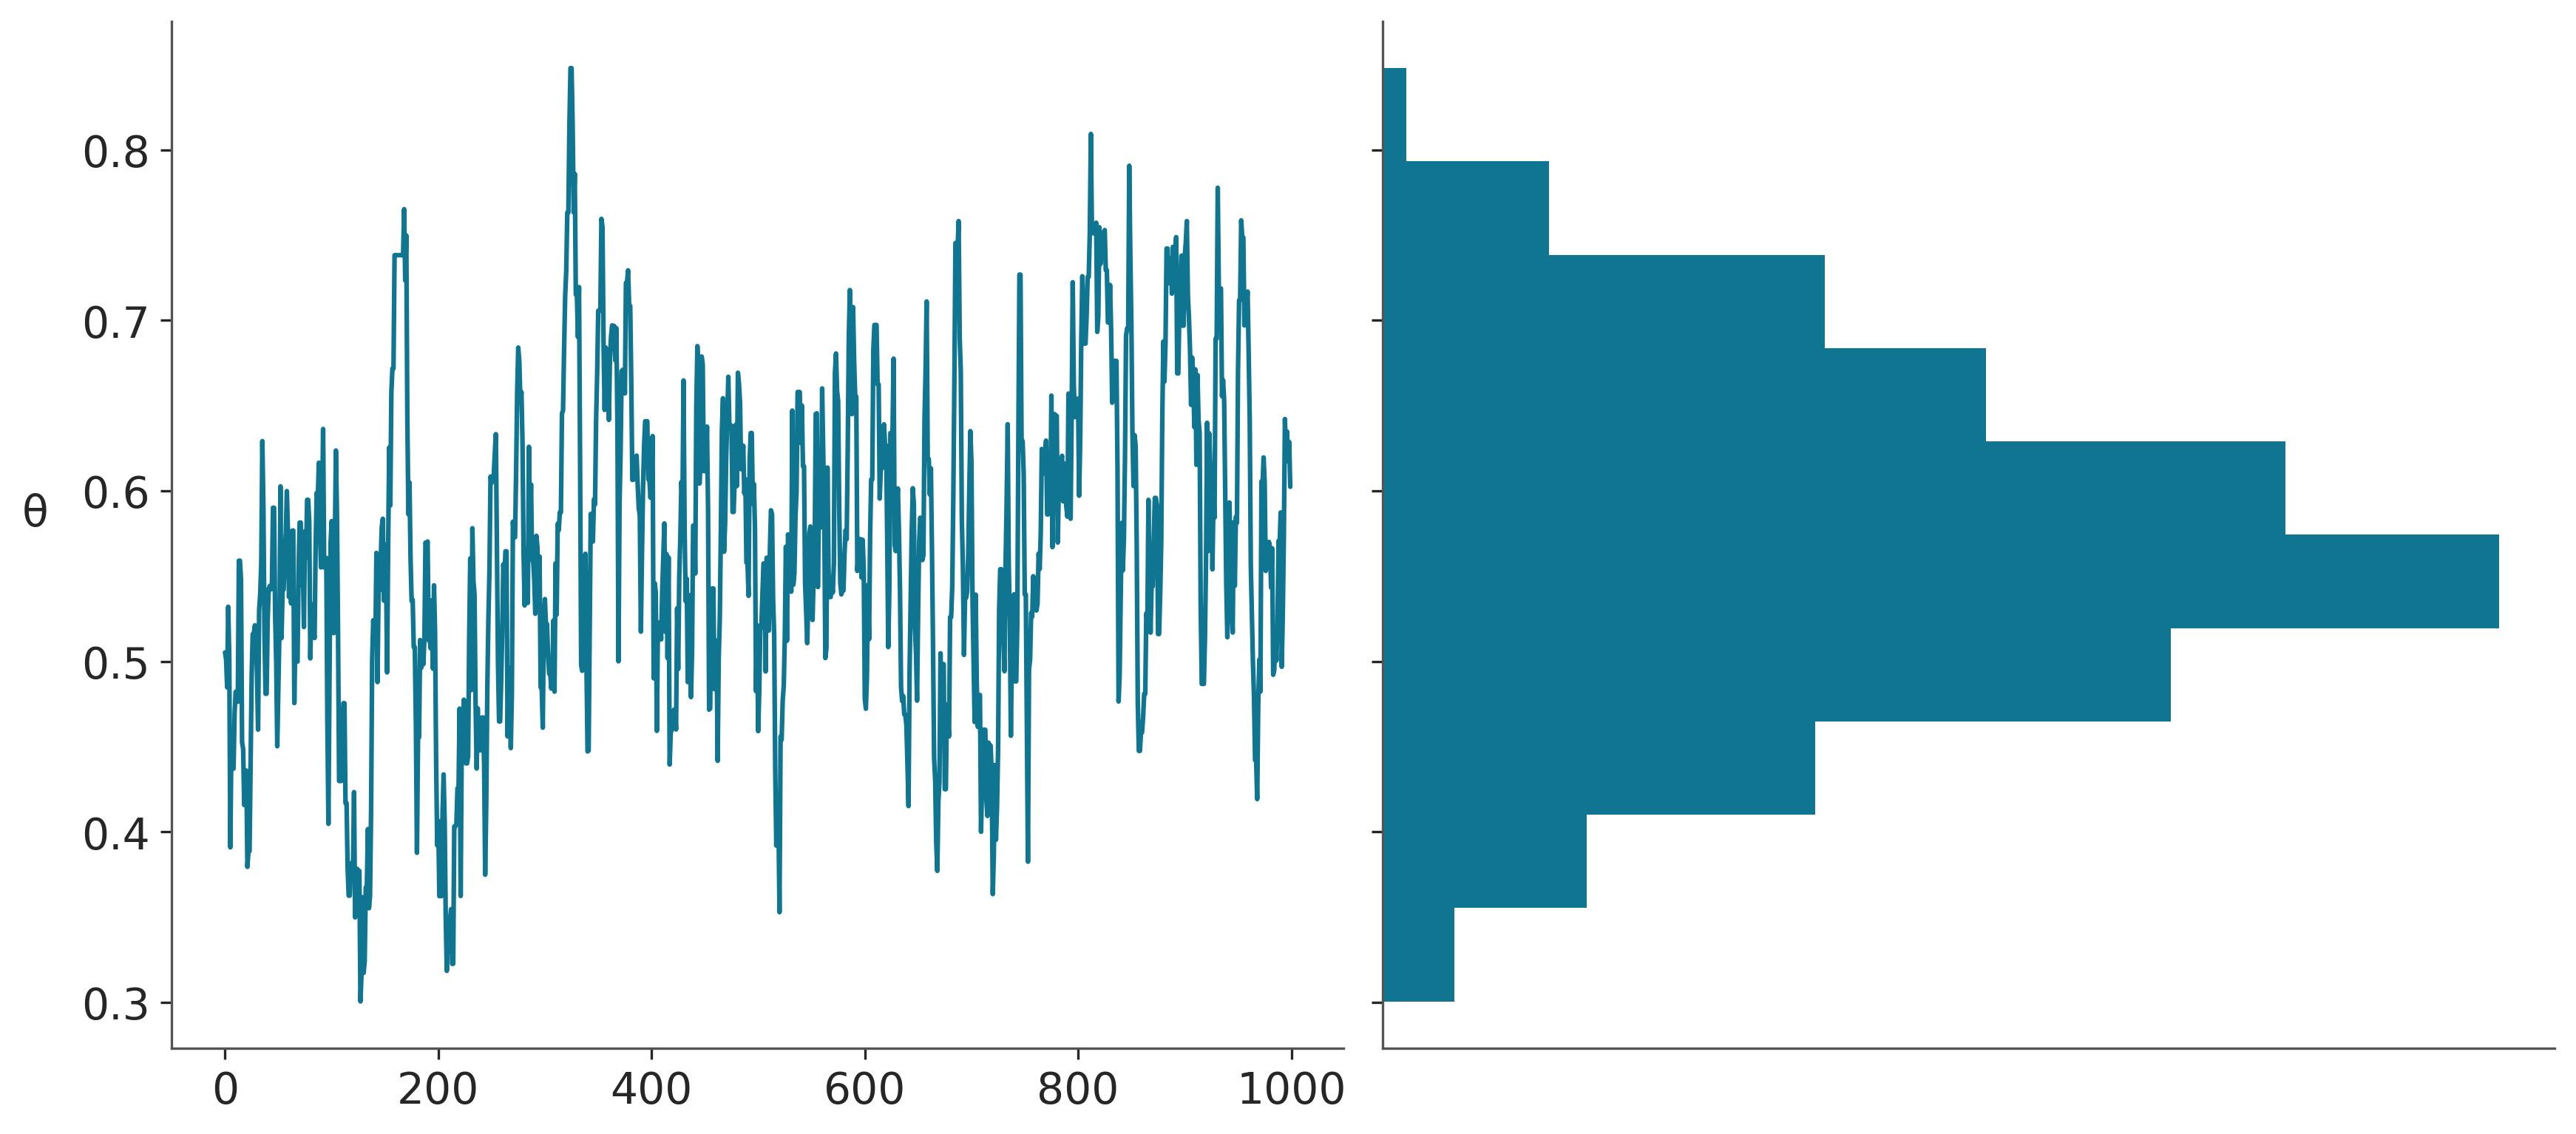

In [19]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['θ'])
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
axes[1].hist(trace['θ'], orientation="horizontal", density=True)
axes[1].set_xticks([]);

### Metropolis-Hastings en detalle

Ahora veremos algunos detalles teóricos sobre el método. Esta sección puede ser omitida sin pérdida de dignidad.

La probabilidad de aceptación viene dada por:

$$
p_a (x_{i + 1} \mid x_i) = \min \left (1, \frac{p(x_{i + 1}) \; 
q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
$$

Es decir, proponemos con probabilidad $q_{ij}$ (léase el subíndice $ij$ como
de $i$ a $j$) y se acepta la propuesta con probabilidad $a_{ij}$. Una de las ventajas de este método es que no necesitamos saber la constante de normalización de la distribución que queremos muestrear, ya que esa constante se cancela cuando calculamos $\frac{p_j}{p_i}$. Esto es muy importante porque en muchos problemas, incluida la inferencia Bayesiana, computar esa constante de normalización (la verosimilitud marginal) es muy
difícil.


Ahora probaremos que este método es correcto, es decir que la cadena generada por el método de Metropolis-Hastings es estacionaria con distribución $p$. Para probar ese es suficiente probar la condición de balance detallado.

Sea $\mathbf{T}$ la matriz de transición, solo necesitamos mostrar que $p_i t_{ij} = p_j t_{ji}$ para todos los $i$ y $j$, esto es trivial cuando $i = j$ por lo que asumimos que $i \neq j$, podemos escribir:


$$
t_{ij} = q_{ij} a_{ij} \tag{4.1}
$$

Lo que significa que la probabilidad de transición de $i$ a $j$ es la probabilidad de proponer el movimiento por la probabilidad de aceptarlo. Veamos primero el caso donde la probabilidad de aceptación es menor
que 1, esto pasa cuando $p_j q_{ji} \le p_i q_{ij}$, entonces tenemos que

$$
a_{ij} = \frac{p_j q_{ji}}{p_i q_{ij}} \tag{4.2}
$$

y también

$$
a_{ji} = 1
$$

Usando la ecuación $4.1$, tenemos

$$
p_i t_{ij} = p_i q_{ij} a_{ij}
$$


reemplazando $a_{ij}$ in la expresión $4.2$

$$
p_i t_{ij} = p_i q_{ij} \frac{p_j q_{ji}}{p_i q_{ij}}
$$


simplificando obtenemos:

$$
p_i t_{ij} = p_j q_{ji}
$$

Como $a_{ji} = 1$ podemos incluirlo sin cambiar la validez de la expresión

$$
p_i t_{ij} = p_j q_{ji} a_{ji}
$$

finalmente obtenemos

$$
p_i t_{ij} = p_j t_{ji}
$$


Por simetría cuando $p_j q_{ji} > p_i q_{ij}$ llegaremos al mismo resultado. Como se cumple la condición de reversibilidad, $p$ es la distribución estacionario de nuestra cadena de Markov con matriz de transición $\mathbf{T}$.

La prueba anterior nos da la confianza teórica de que podemos usar Metropolis-Hastings para muestrear de  prácticamente cualquier distribución que queramos. También podemos ver que este es un resultado muy general, y no probee de pistas sobre como elegir una distribución de propuesta.

En la práctica la distribución de propuesta es muy importante ya que la eficiencia del método depende fuertemente en esta elección. En general se observa que si la propuesta hace grandes saltos la probabilidad de aceptación es muy baja, y el método rechazará la mayoría de los nuevos estados. Por el contrario, si la propuesta da saltos demasiado pequeños, la la tasa de aceptación será alta pero la exploración del espacio de los parámetros sera muy pobre.


Entonces una buena distribución de propuesta será aquella que genera nuevos estados lejos del
antiguo estado con alta tasa de aceptación. Esto es generalmente difícil de hacer si no conocemos la geometría de la distribución posterior, que es precisamente lo que queremos averiguar. En la práctica lo métodos útiles tienen que ser adaptativos. Por ejemplo, podemos usar una distribución gaussiana multivariada como distribución de propuesta y realizar unos pasos de pruena o pasos de "ajust" (tuning), lo que usaremos para calcular la covarianza empírica de las muestras. Luego podemos utilizar esa covarianza para modificar la distribución de propuesta. Existe evidencia empírica y teórica indicando que la tasa de aceptación optima de los métodos de Metropolis-Hastings es de  0.4 para una dimensión y converge a 0.234 a medida que el número de parámetros se aproxima a infinito. También se sabe que en este caso "infinito" es basicamente menos de 10. Es decir aún si logramos obtener una buena distribución de propuesta recharazeremos más del 75% de los puntos propuestos.

En la siguiente sección discutiremos una forma inteligente de generar propuestas.

### Montecarlo Hamiltoniano (HMC)

Este es  un tipo de método MCMC que hace uso de gradientes para proponer nuevos estados. Los gradientes proporcionan información de la geometría del posterior. De esa forma, HMC intenta evitar el comportamiento de paseo aleatorio típico de Metropolis-Hastings utilizando el gradiente para proponer nuevas posiciones lejos
de la actual, pero con alta probabilidad de aceptación. Esto permite a HMC escalar mejor a dimensiones más altas y en principio más complejas.

En términos simples, un hamiltoniano es una descripción de la energía total de un sistema físico. Podemos descomponer la energía total en dos términos, el cinética y la energía potencial. Para un sistema real como una pelota que rueda cuesta abajo, la energía potencial viene dada por la posición de la pelota. Cuanto más alta se encuentre la pelota, mayor será la energía potencial. La energía cinética viene dada por la velocidad de la pelota, o más correctamente por su momemtum (que tiene en cuenta tanto la velocidad como la masa del objeto).
Supongamos que la energía total se conserva, lo que significa que si el sistema gana energía cinética entonces es porque ha perdido la misma cantidad de energía potencial. Podemos escribir el hamiltoniano de tales sistemas como:

$$
H(\mathbf{q}, \mathbf{p})  = K(\mathbf{p}, \mathbf{q}) + V(\mathbf{q})
$$

donde $K(\mathbf{p}, \mathbf{q})$ se llama energía cinética, y
$V(\mathbf{q})$ es la energía potencial. La probabilidad de encontrar la pelota en una posición particular con un impulso particular es:

$$
p(\mathbf{q}, \mathbf{p}) = e^{-H(\mathbf{q}, \mathbf{p})} \tag{4.3}
$$

Para simular estos sistemás necesitamos resolver las ecuaciones Hamiltonianas:


\begin{aligned}
\frac{d \mathbf{q}}{dt} =& \quad \frac{\partial H}{\partial \mathbf{p}} = \frac{\partial K}{\partial \mathbf{p}} + \frac{\partial V}{\partial \mathbf{p}} \\
\frac{d \mathbf{p}}{dt} =& -\frac{\partial H}{\partial \mathbf{q}}= -\frac{\partial K}{\partial \mathbf{q}} - \frac{\partial V}{\partial \mathbf{q}}
\end{aligned}

Tenga en cuenta que $\frac{\parcial V}{\parcial \mathbf{p}} = \mathbf{0}$.

Ya que no estamos interesados en modelar una pelota idealizada rodando hacia abajo de una colina idealizada, si no que queremos modelar una partícula idealizada a lo largo de la distribución posterior, necesitamos hacer algunos ajustes. Primero la energía potencial está dada por la densidad de probabilidad que estamos tratando de
muestrar, $p(\mathbf{q})$, es decir el posterior. Para el momemtum, vamos a invocar una variable auxiliar. Es decir, una variable inventada. Si elegimos $p(\mathbf{p} \mid \mathbf{q})$ entonces podemos escribir:

$$
p(\mathbf{q}, \mathbf{p}) = p(\mathbf{p} | \mathbf{q}) p(\mathbf{q}) \tag{4.4}
$$


Esto nos asegura que podemos recuperar nuestra distribución objetivo al marginalizar el momemtum. Al introducir la variable auxiliar, podemos continuar trabajando con la analogía física, y luego al eliminarla podemos volver al problema que realmente no interesa, obtener muestras del posterior.


Si reemplazamos 4.3 en 4.4 obtenemos:

$$
H(\mathbf{q}, \mathbf{p}) = \overbrace{-\log p(\mathbf{p} \mid \mathbf{q})}^{K(\mathbf{p}, \mathbf{ q})} \overbrace{- \log p(\mathbf{q})}^{ + V(\mathbf{q})}
$$

Como se explicó anteriormente, la energía potencial $V(\mathbf{q})$ está dada
por $p(\mathbf{q})$ la función de densidad de la distribución a posteriori y somos libres de elegir la energía cinética. Si elegimos una gaussiana y suprimimos la constante de normalización, tenemos:

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T M^{-1}\mathbf{p} + \log |M|
$$

donde $M$ es la **matriz de precisión** que parametriza la distribución Gaussiana (también conocida como la matriz de masa). Y si elegimos $M = I$, es decir, la matriz identidad, una matriz cuadrara de $n \times n$ con unos en la diagonal principal y ceros en otros lugares, tenemos:

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T \mathbf{p}
$$

Esto hace que los cálculos sean más fáciles como ahora.

$$
\frac{\parcial K}{\mathbf{p}} = \mathbf{p}
$$

$$
\frac{\parcial K}{\mathbf{q}} = \mathbf{0}
$$

Entonces podemos simplificar las ecuaciones Hamiltonianas:


\begin{align}
\frac{d \mathbf{q}}{dt} =& \mathbf{p} \\
\frac{d \mathbf{p}}{dt} =& - \frac{\parcial V}{\parcial \mathbf{q}}
\end{align}


Resumiendo, el algoritmo HMC es entonces:

1. Muestreamos $\mathbf{p} \sim \mathcal{N}(0, I)$

2. Simulamos $\mathbf{q}_t$ y $\mathbf{p}_t$ durante un período de tiempo
    $T$

3. $\mathbf{q}_T$ es nuestro nuevo estado propuesto

4. Utilizamos el criterio de aceptación de Metropolis para aceptar o rechazar
    $\mathbf{q}_T$.

¿Por qué todavía necesitamos usar el criterio de aceptación de Metropolis?
Intuitivamente  podemos pensar en HMC como un Metropolis-Hasting con una mejor distribución de propuestas. Pero también hay una muy buena justificación numérica, este paso corrige errores introducido por la simulación numérica de las ecuaciones Hamiltonianas.

Para calcular las ecuaciones hamiltonianas tenemos que calcular una trayectoria de la partícula, es decir, todos los puntos intermedios entre un estado y el siguiente. En la práctica, esto implica calcular una serie de pequeños pasos de *integración* usando un método integrador. El más popular es
se llama leap-frog. La integración de Leapfrog es equivalente a actualizar la posición y el momento impulso de forma intercalada.

In [ ]:

Code Block [leapfrog](leapfrog) shows a leapfrog
integrator implemented in Python [^26]. The arguments are: `q` and `p`
the initial position and momentum respectively. `dVdq` is a Python
function that returns the gradient of the position of some target
density function at position `q`
$\frac{\partial V}{\partial \mathbf{q}}$. We used JAX {cite:p}`jax2018github`
auto-differentiation ability to generate this function. `path_len`
indicates how long to integrate for and `step_size` how large each
integration step should be. As a result we obtain a new position and
momentum as output of the function `leapfrog`.

```{code-block} python
:name: leapfrog
:caption: leapfrog

def leapfrog(q, p, dVdq, path_len, step_size):
    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    return q, -p  # momentum flip at end
```

Note that in function `leapfrog` we flip the sign of the output
momentum. This is the simplest way to achieve a reversible
Metropolis-Hastings proposal, as it augment the numerical integration
with a negative step.

We have now all the ingredients to implement a HMC method in Python, as
in Code Block [hamiltonian_mc](hamiltonian_mc). Like our previous
Metropolis-Hasting example in Code Block [metropolis_hastings](metropolis_hastings) this is
not meant to be use for serious model inference but instead a simple
example to demonstrate the method. The arguments are `n_samples` the
number of samples to return, `negative_log_prob` the negative log
probability to sample from, `initial_position` the initial position to
start sampling, `path_len`, `step_size`, as a result we obtain sample
from the target distribution.

```{code-block} python
:name: hamiltonian_mc
:caption: hamiltonian_mc

def hamiltonian_monte_carlo(
    n_samples, negative_log_prob, initial_position, 
    path_len, step_size):
    # autograd magic
    dVdq = jax.grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = stats.norm(0, 1)
    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1], p0, dVdq, path_len=path_len, step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])
```

{numref}`fig:normal_leapgrog` shows 3 different trajectories around the
same 2D normal distribution. For practical sampling we do not want the
trajectories to be circular, because they will arrive at the same
position that we started at. Instead we want to move as far as possible
from our starting point, for example, by avoiding U-turns in the
trajectory, and hence the name of one of the most popular dynamic HMC
method No U-Turn Sampling (NUTS).

```{figure} figures/normal_leapfrog.png
:name: fig:normal_leapgrog
:width: 8.00in
Three HMC trajectories *around* a 2D multivariate normal. The momentum
is indicated by the size and direction of the arrows, with small arrows
indicating small kinetic energy. All these trajectories are computed in
such a way that they end at their starting position, which completing an
elliptical trajectory.
```

We show another example in {numref}`fig:funnel_leapgrog`, which contains
3 different trajectory around the same Neal's funnel, a common geometry
arising in (centered) hierarchical models as we showed in Section {ref}`model_geometry`. 
This is an example of
a trajectory failing to properly simulate following the correct
distribution, we call such trajectories divergent trajectories, or
simply divergences. They are useful diagnostics as explained in Section
{ref}`divergences`. Usually, Symplectic integrators like
leapfrog integrator are highly accurate even for long trajectories, as
they tend to be tolerant of small errors and *oscillate* around the
correct trajectory. Moreover, these small errors can be corrected
exactly by applying the metropolis criteria to accept or reject the
Hamiltonian proposal. However, there is an importance exception to this
ability to generate small, easy to fix errors: when the exact
trajectories lie on regions of high curvature, the numerical
trajectories generated by symplectic integrators can diverge, generating
trajectory that rapidly get off towards the boundaries of the
distribution we are trying to explore.

```{figure} figures/funnel_leapfrog.png
:name: fig:funnel_leapgrog
:width: 8.00in
Three HMC trajectories *around* a 2D Neal's funnel. This kind geometry
turns up in centered hierarchical models. We can see that all these trajectories went wrong.
We call this kind of trajectories divergences and can be used as a diagnostic of HMC samplers.
```

Both Figures {numref}`fig:normal_leapgrog` and
{numref}`fig:funnel_leapgrog` highlight the fact that an efficient HMC
method requires proper tuning of its hyperparameters. HMC has three
hyparameters:

-   the time discretization (step size of the leapfrog)

-   the integration time (number of leapfrog steps)

-   the precision matrix $M$ that parameterized the kinetic energy

For example, if the step size is too large, the leapfrog integrator will
be inaccurate and too many proposals will be rejected. However, if it is
too small we will waste computation resources. If the number of steps is
too small, the simulated trajectory at each iteration will be too short
and sampling will fall back to random walk. But if it is too large the
trajectory might runs in circles and we again waste computation
resources. If the estimated covariance (inverse of the precision matrix)
is too different from the posterior covariance, the proposal momentum
will be suboptimal and the movement in the position space will be too
large or too small in some dimension.

Adaptive dynamics Hamiltonian Monte Carlo methods, like those used by
default in PyMC3, Stan and other PPLs can adapt these hyperparameters
automatically during the warm-up or tuning phase. The step size can be
learning automatically by adjusting it to match a predefined
acceptance-rate target. For example, in PyMC3 you set the argument
`target_accept` [^27] The precision matrix $M$ or its inverse can be
estimated from the samples during warm-up phase and the number of steps
can be dynamically adapted at each MCMC step using the NUTS algorithm
{cite:p}`Hoffman2014`. In order to avoid too long trajectory that could go near
the initialization point, NUTS extends the trajectory backward and
forwards until a U-turn criterion is met. Additionally, NUTS applies a
multinomial sampling to choose from all the generated points from the
trajectory, as this provides a better criteria for efficient exploration
of the target distribution (sampling from the trajectory could be done
with fixed integration time HMC as well).

(smc_details)=

In [ ]:


### Sequential Monte Carlo

Sequential Monte Carlo is a family of Monte Carlo methods also known as
particle filters. It has wide application to Bayesian inference for
static models and dynamic models such as sequential time series
inference and signal processing
{cite:p}`delmoral2006, Ching2007, Naesseth2019, Chopin2020`. There are many
variations and implementation under the same or similar name, with
different application. Thus you might at times find the literature a bit
confusing. We will give a brief description of the SMC/SMC-ABC method as
implemented in PyMC3 and TFP. For a detailed discussion of SMC methods
under a unified framework we recommend the book An Introduction to
Sequential Monte Carlo {cite:p}`Chopin2020`.

First note that we can write the posterior in the following way:

```{math}
:label: eq:powered_posterior
p(\boldsymbol{\theta} \mid Y)_{\beta}  \propto 
    p(Y \mid \boldsymbol{\theta})^{\beta} \; p(\boldsymbol{\theta})
```

When $\beta = 0$ we see that $p(\boldsymbol{\theta} \mid Y)_{\beta}$ is
the prior and when $\beta = 1$ we see that
$p(\boldsymbol{\theta} \mid Y)_{\beta}$ is the *true* posterior [^28].

SMC proceeds by increasing the value of $\beta$ in $s$ successive stages
$\{\beta_0=0 < \beta_1  < ...  < \beta_s=1\}$. Why is this a good idea?
There are two related ways to justify it. First, the stepping stones
analogy. Instead of directly trying to sample from the posterior we
begin by sampling from the prior, which is generally easier to do. Then
we add some intermediate distributions until we reach the posterior (see
{numref}`fig:smc_tempering`). Second is the temperature
analogy. The $\beta$ parameters is analogue to the inverse temperature
of a physical system, as we decrease its value (increase the
temperature) the system is able to access to more states, and as we
decrease its value (decrease the temperature) the system "freezes\" into
the posterior [^29]. {numref}`fig:smc_tempering` shows an
hypothetical sequence of tempered posteriors. The use of the temperature
(or its inverse) as an auxiliary parameter is known as tempering, the
term annealing is also common [^30].

The SMC method, as implemented in PyMC3 and TFP, can be summarized as
follows:

1.  Initialize $\beta$ at zero.

2.  Generate $N$ samples $s_{\beta}$ from the tempered posterior.

3.  Increase $\beta$ in order to keep the effective sample size [^31] at
    a predefined value.

4.  Compute a set of $N$ importance weights $W$. The weights are
    computed according to the new and old tempered posterior.

5.  Obtain $s_w$ by resampling $s_{\beta}$ according to $W$.

6.  Run $N$ MCMC chains for $k$ steps, starting each one from a
    different sample in $s_w$ and retaining only the samples in the last
    step.

7.  Repeat from step 3 until $\beta=1$

The resampling step works by removing samples with a low probability and
replacing them with samples with a higher probability. This step
decreases the diversity of the samples. Then, the MCMC step perturbs the
samples, hopefully increasing the diversity and therefore helping SMC to
explore the parameter space. Any valid MCMC transition kernel could be
used in SMC, and depending on your problem you might find some perform
better than others. For example, with ABC methods we generally need to
rely on gradient-free methods such as Random Walk Metropolis-Hasting as
the simulators are generally not differentiable.

The efficiency of the tempered method depends heavily on the
intermediate values of $\beta$. The smaller the difference between two
successive values of $\beta$, the closer the two successive tempered
posteriors will be, and thus the easier the transition from one stage to
the next. But if the steps are too small, we will need many intermediate
stages, and beyond some point this will waste a lot of computational
resources without really improving the accuracy of the results. Another
important factor is the efficiency of the MCMC transitional kernel that
adds diversity to the samples. To help improve the efficiency of the
transition, PyMC3 and TFP uses the samples from the previous stage to
tune the proposal distribution of the current stage and also the number
of steps taken by the MCMC, with the number of steps being the same
across all chains.

(vi_details)=



### Variational Inference

While we do not use variational inference in this book, it is a useful
approach to know about. Compared to MCMC, VI tends to be easier to scale
to large data and is faster to run computationally, but with less
theoretical guarantees of convergence {cite:p}`yao2018yes`.

As we previously mentioned in Section {ref}`DKL`, we can use one distribution to
approximate another and then use the Kullback-Leibler (KL) divergence to
measure how good the approximation is. Turns out we can use this
approach to do Bayesian inference as well! Such approach is called
variational inference (VI) {cite:p}`Blei_2017`. The goal of VI is to
approximate the target probability density, in our case the posterior
distribution $p(\boldsymbol{\theta} \mid Y)$, with a surrogate
distribution $q(\boldsymbol{\theta})$. In practice we usually choose
$q(\boldsymbol{\theta})$ to be of simpler form than
$p(\boldsymbol{\theta} \mid Y)$, and we find the member of that family
of distributions, which is the closest to the target in the KL
divergence sense, using optimization. With small rewrite to Equation
{eq}`eq:kl_divergence`, we have:

```{math} 
:label: eq:kl_divergence2
\mathbb{KL}(q(\boldsymbol{\theta}) \parallel p(\boldsymbol{\theta} \mid Y)) = \mathbb{E}_q[\log{q(\boldsymbol{\theta})}-\log{p(\boldsymbol{\theta} \mid Y)}]
    
```

However, this objective is hard to compute because it requires the
marginal likelihood of $p(Y)$. To see that let us expand Equation
{eq}`eq:kl_divergence2`:

```{math}
:label: eq:kl_divergence2_expanded
\begin{split}
    \mathbb{KL}(q(\boldsymbol{\theta}) \parallel p(\boldsymbol{\theta} \mid Y)) &= \mathbb{E}[\log{q(\boldsymbol{\theta})}] - \mathbb{E}[\log{p(\boldsymbol{\theta} \mid Y)}] \\
   &= \mathbb{E}[\log{q(\boldsymbol{\theta})}] - \mathbb{E}[\log{p(\boldsymbol{\theta},  Y)}] + \log{p(Y)}
\end{split}
```

Luckily, since $\log{p(Y)}$ is a constant with respect to
$q(\boldsymbol{\theta})$, we can omit it during optimization. Thus, in
practice, we maximize the evidence lower bound (ELBO) as shown in
Equation {eq}`eq:elbo_vi`, which is equivalent to minimizing the KL
divergence:

```{math} 
:label: eq:elbo_vi
\text{ELBO}(q) = \mathbb{E}[\log{p(\boldsymbol{\theta},  Y)}] - \mathbb{E}[\log{q(\boldsymbol{\theta})}]
    
```

The last piece of the puzzle is to figure out how to compute the
expectation in Equation {eq}`eq:elbo_vi`. Instead of solving an
expensive integration, we compute the average using Monte Carlo samples
drawn from the surrogate distribution $q(\boldsymbol{\theta})$ and plug
them into {eq}`eq:elbo_vi`.

The performance of VI depends on many factors. One of them being the
family of surrogate distributions we choose from. For example, a more
expressive surrogate distribution helps capture more complex, nonlinear
dependencies among components of the target posterior distribution, and
thus usually gives better result (see {numref}`fig:vi_in_tfp`).
Automatically choosing a good surrogate family distribution and
efficiently optimizing it is currently an active research area. Code
Block [vi_in_tfp](vi_in_tfp) shows a simple example of
using VI in TFP, with two different types of surrogate posterior
distributions. The result is shown in {numref}`fig:vi_in_tfp`.

```{code-block} python
:name: vi_in_tfp
:caption: vi_in_tfp

tfpe = tfp.experimental
# An arbitrary density function as target
target_logprob = lambda x, y: -(1.-x)**2 - 1.5*(y - x**2)**2

# Set up two different surrogate posterior distribution
event_shape = [(), ()]  # theta is 2 scalar
mean_field_surrogate_posterior = tfpe.vi.build_affine_surrogate_posterior(
    event_shape=event_shape, operators="diag")
full_rank_surrogate_posterior = tfpe.vi.build_affine_surrogate_posterior(
    event_shape=event_shape, operators="tril")

# Optimization
losses = []
posterior_samples = []
for approx in [mean_field_surrogate_posterior, full_rank_surrogate_posterior]:
    loss = tfp.vi.fit_surrogate_posterior(
        target_logprob, approx, num_steps=100, optimizer=tf.optimizers.Adam(0.1),
        sample_size=5)
    losses.append(loss)
    # approx is a tfp distribution, we can sample from it after training
    posterior_samples.append(approx.sample(10000))
```

```{figure} figures/vi_in_tfp.png
:name: fig:vi_in_tfp
:width: 8.00in
Using variational inference to approximate a target density function.
The target density is a 2D banana shaped function plotted using contour
lines. Two types of surrogate posterior distributions are used for the
approximation: on the left panel a mean-field Gaussian (one univariate
Gaussian for each dimension with trainable location and scale) and on
the right panel a full-rank Gaussian (a 2D multivariate Gaussian with
trainable mean and covariance matrix) {cite:p}`kucukelbir2016automatic`.
Samples from the approximation after optimization are plotted as dots
overlay on top of the true density. Comparing the two, you can see that
while both approximations does not fully capture the shape of the target
density, full-rank Gaussian is a better approximation thanks to its more
complex structure.
```

[Computing Bayes: Bayesian Computation from 1763 to the 21st Century](https://arxiv.org/abs/2004.06425).